In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Constants
SEED = 42
random.seed(SEED)
PAY = 1.95 # PAY * BETinit should be an integer value
Ntrials = 1500 #100,000 takes est. 1hr @ 16GB RAM. 1500 produces quick results 40 seconds
BANKinit = 200000
BETinits = [20,200,2000,20000,40000,200000]
GOAL = 2

In [2]:
def simulate_one_trial(PAY, BANKinit, BETinit, GOAL):
    bank = BANKinit  # Reset bank for each trial
    bet_amt = BETinit
    
    # Play until bank < BETinit or bank >= GOAL * BANKinit
    while bank >= BETinit and bank < GOAL * BANKinit:
        if bet_amt > bank:  # If you cannot afford bet_amt, reset to BETinit
            bet_amt = BETinit
        
        bank -= bet_amt  # Place the bet
        
        if random.randint(1, 2) == 1:  # Win condition
            bank += PAY * bet_amt  # Add PAY times bet_amt to bank
            bet_amt = BETinit  # Reset bet to initial amount
        else:  # Loss condition
            bet_amt *= 2  # Double the bet amount
    return bank

In [3]:
avg_scalar_effects = []
bet_inits_as_prop = []
for BETinit in BETinits:
    # Reset variables
    win = 0
    lose = 0
    total_winnings = 0
    total_losses = 0
    for i in range(Ntrials):
        bankEnd = simulate_one_trial(PAY, BANKinit, BETinit, GOAL)
        
        # Check if the goal is met or not
        if bankEnd >= GOAL * BANKinit:
            win += 1
            total_winnings += bankEnd - BANKinit
        else:
            lose += 1
            total_losses += BANKinit - bankEnd

    win_percentage = win / Ntrials
    avg_profit = (total_winnings - total_losses) / Ntrials
    avg_scalar_effect = 1 + (avg_profit / BANKinit)
    avg_scalar_effects.append(avg_scalar_effect)
    bet_inits_as_prop.append(BETinit/BANKinit)

In [4]:
# While scikit-learn doesn't directly offer a logarithmic regression model,
# we can achieve the desired fit by transforming the independent variable (x)
# before feeding it to a linear regression model.

#Prepare the data:
x_data = np.array(bet_inits_as_prop).reshape(-1, 1)  # Reshape for sklearn
y_data = np.array(avg_scalar_effects)

#Transform the independent variable:
x_log = np.log(x_data)

#Create and fit a linear regression model:
model = LinearRegression()
model.fit(x_log, y_data)

#Make prediction:
y_pred = model.predict(x_log)

#Get the coefficients:
a = model.coef_[0]
b = model.intercept_
#print(f"Model Coef: {a}")
#print(f"Model Intercept: {b}")

#Evaluate the fit (R-squared) and RMSE:
r2 = r2_score(y_data, y_pred)
rmse = np.sqrt(mean_squared_error(y_data, y_pred))
#print(f"r^2: {r2}")
#print(f"rmse: {rmse}")

#Plot the results:

# To plot the fitted curve, we need to apply the inverse transformation to x for plotting:
x_plot = np.linspace(x_data.min(), x_data.max(), 100).reshape(-1, 1) # Create points for plotting
x_plot_log = np.log(x_plot) # Transform plotting x
y_plot_fit = model.predict(x_plot_log) # Predict y-values
#y_plot_alt = a*x_plot_log + b

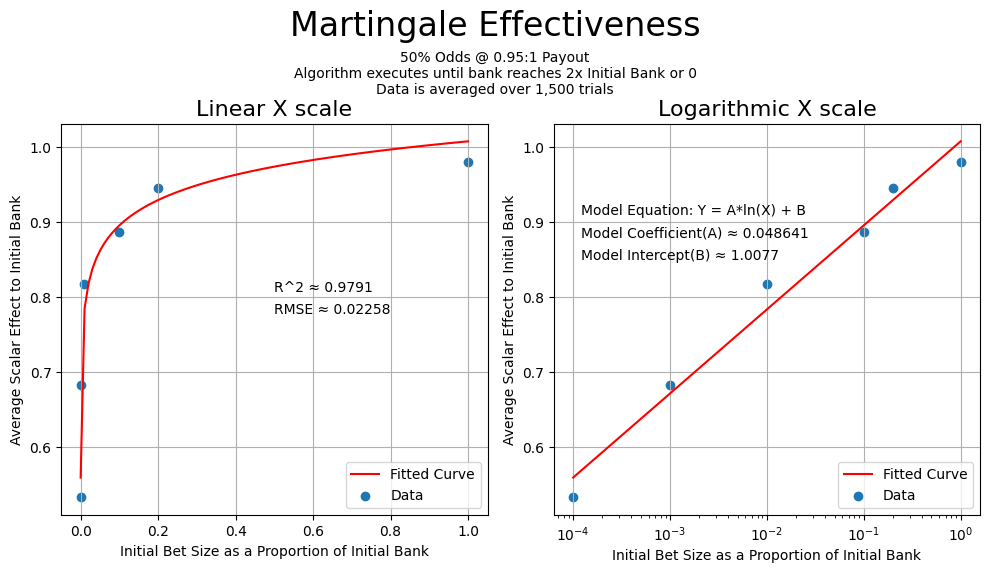

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5.8))

axes[0].plot(x_plot, y_plot_fit, color="red", label="Fitted Curve")
axes[0].scatter(x_data, y_data, label="Data")
axes[0].set_xlabel('Initial Bet Size as a Proportion of Initial Bank')
axes[0].set_ylabel('Average Scalar Effect to Initial Bank')
axes[0].set_title("Linear X scale",fontsize=16)
axes[0].grid(True)
axes[0].legend(loc='lower right')

axes[1].plot(x_plot, y_plot_fit, color="red", label="Fitted Curve")
axes[1].scatter(x_data, y_data, label="Data")
axes[1].set_xlabel('Initial Bet Size as a Proportion of Initial Bank')
axes[1].set_ylabel('Average Scalar Effect to Initial Bank')
axes[1].set_title("Logarithmic X scale",fontsize=16)
axes[1].grid(True)
axes[1].legend(loc='lower right')
axes[1].set_xscale('log')

spacing = 0.03

x_start0 = .5
y_start0 = .808

axes[0].text(x_start0,y_start0,f"R^2 ≈ {r2:.4f}")
axes[0].text(x_start0,y_start0-spacing,f"RMSE ≈ {rmse:.5f}")

x_start1 = .00012
y_start1 = .91

axes[1].text(x_start1, y_start1,f"Model Equation: Y = A*ln(X) + B")
axes[1].text(x_start1, y_start1 - spacing, f"Model Coefficient(A) ≈ {a:.6f}")
axes[1].text(x_start1, y_start1 - 2*spacing, f"Model Intercept(B) ≈ {b:.4f}")

fig.text(.5,.83, f"50% Odds @ {PAY-1}:1 Payout\n"
         f"Algorithm executes until bank reaches {GOAL}x Initial Bank or 0\n"
         f"Data is averaged over {Ntrials:,} trials", ha='center', va='bottom')
fig.suptitle(f"Martingale Effectiveness\n",fontsize=24)
fig.tight_layout()  # Important to prevent overlapping labels
fig.savefig(f"Martingale_fig_{SEED}_{Ntrials}.png")

plt.show()